<a href="https://colab.research.google.com/github/ahmedSadoun/colab-project/blob/main/vgg16_final_success.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


100% 2.29G/2.29G [00:19<00:00, 117MB/s] 
100% 2.29G/2.29G [00:20<00:00, 123MB/s]


In [ ]:
import zipfile
zf = "/content/chest-xray-pneumonia.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
import os
import pandas as pd
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model
image_width = 224
image_height = 224
channels = 3
batch_size = 16

train_dir = '/content/dataset/cnn/pneumonia_revamped/chest_xray/train'
test_dir = '/content/dataset/cnn/pneumonia_revamped/chest_xray/test'
valid_dir = '/content/dataset/cnn/pneumonia_revamped/chest_xray/val'
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)
train = image_gen.flow_from_directory(
      train_dir,
      target_size=(image_height, image_width),
      color_mode='rgb',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_dir,
      target_size=(image_height, image_width),
      color_mode='rgb',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_dir,
      target_size=(image_height, image_width),
      color_mode='rgb',
      class_mode='binary', 
      batch_size=batch_size
      )
# Loading Model
pretrained_model = VGG16(input_shape=(image_height, image_width, channels), include_top=False, weights="imagenet")
pretrained_model.summary()



In [ ]:

# Freezing the layers
for layer in pretrained_model.layers[:15]:
    layer.trainable = False
for layer in pretrained_model.layers[15:]:
    layer.trainable = True
 
# Modification of pretrained model
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output
 
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
 
# Creating a new model
model = Model(pretrained_model.input, x)
 
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
 
model.summary()


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="loss", mode="min",min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]
# Training model
n_training_samples = len(train)
n_validation_samples = len(valid)

history = model.fit(
    train,
    epochs=30,
    validation_data=valid,
    validation_steps=n_validation_samples//batch_size,
    steps_per_epoch=n_training_samples//batch_size
    ,callbacks=callbacks_list
    )

In [ ]:

#nb_samples = test_dir.shape[0]
predict = model.predict(test)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

score, acc = model.evaluate(test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

39/39 [==============================] - 205s 5s/step - loss: 0.6902 - accuracy: 0.6016
Test score: 0.41796445846557617
Test accuracy: 0.7932692170143127


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
print('f1 score ',f1_score(predict.round(),test.classes,average='micro'))
print('accuracy ',accuracy_score(predict.round(),test.classes))
print('recall ',recall_score(predict.round(),test.classes,average=None))
print('precision ',precision_score(predict.round(),test.classes,average=None))

f1 score  0.7932692307692307
accuracy  0.7932692307692307
recall  [0.92682927 0.76047904]
precision  [0.48717949 0.97692308]


AUC Value  :  0.7320512820512821


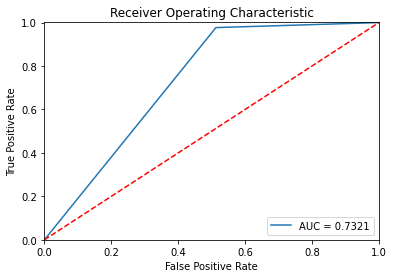

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fprValue2, tprValue2, thresholdsValue2 = roc_curve(test.classes,predict.round())
AUCValue = auc(fprValue2, tprValue2)
print('AUC Value  : ', AUCValue)
plt.title('Receiver Operating Characteristic')
plt.plot(fprValue2, tprValue2, label='AUC = %0.4f'% AUCValue)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

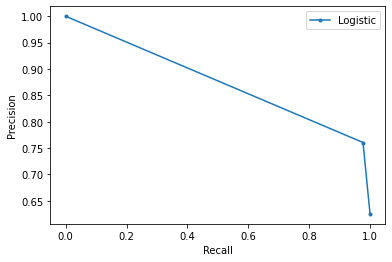

In [ ]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
precision, recall, _ = precision_recall_curve(test.classes, predict.round())
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

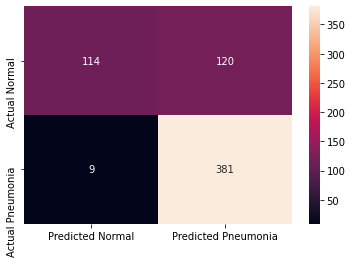

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predict.round()),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
model.save('drive/MyDrive/mymodel')

INFO:tensorflow:Assets written to: drive/MyDrive/mymodel/assets


In [ ]:

model.save("drive/MyDrive/name_of_your_model.h5")

NameError: ignored